# Part 1: Data Exploration & Preparation

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
titanic_df = sns.load_dataset('titanic')

In [3]:
null = titanic_df.isnull().sum()
null_percentage = (null / len(titanic_df)) * 100

print(null)
print(null_percentage)

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64
survived        0.000000
pclass          0.000000
sex             0.000000
age            19.865320
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.224467
class           0.000000
who             0.000000
adult_male      0.000000
deck           77.216611
embark_town     0.224467
alive           0.000000
alone           0.000000
dtype: float64


In [4]:
df_clean = titanic_df.drop(columns=['deck'])
df_clean.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True


In [9]:
# identify redundant features

redundant_pairs = {}

redundant_pairs['sex_who'] = titanic_df['sex'].nunique() == titanic_df['who'].nunique()
redundant_pairs['adult_male_who'] = titanic_df['adult_male'].nunique() == titanic_df['who'].nunique()
redundant_pairs['survived_alive'] = titanic_df['survived'].nunique() == titanic_df['alive'].nunique()
redundant_pairs['class_pclass'] = titanic_df['class'].nunique() == titanic_df['pclass'].nunique()
redundant_pairs['embarked_embark_town'] = titanic_df['embarked'].nunique() == titanic_df['embark_town'].nunique()
redundant_pairs['sex_adult_male'] = titanic_df['sex'].nunique() == titanic_df['adult_male'].nunique()

for pair, is_redundant in redundant_pairs.items():
    print(f"{pair}: {is_redundant}")

sex_who: False
adult_male_who: False
survived_alive: True
class_pclass: True
embarked_embark_town: True
sex_adult_male: True


In [8]:
# confirm sex_who and adult_male_who are not redundant 

unique_sex = list(df_clean['sex'].unique())
print(f" Unique sex: {unique_sex}")

unique_who = list(df_clean['who'].unique())
print(f" Unique who: {unique_who}")

unique_adult_male = list(df_clean['adult_male'].unique())
print(f" Unique adult_male: {unique_adult_male}")

unique_who = list(df_clean['who'].unique())
print(f" Unique who: {unique_who}")


 Unique sex: ['male', 'female']
 Unique who: ['man', 'woman', 'child']
 Unique adult_male: [True, False]
 Unique who: ['man', 'woman', 'child']


In [13]:
# drop redundant columns

df_titanic_clean = df_clean.drop(columns=['sex', 'class', 'alive', 'embarked'])
df_titanic_clean.head()

,survived,pclass,age,sibsp,parch,fare,who,adult_male,embark_town,alone
0,0,3,22.0,1,0,7.2500,man,True,Southampton,False
1,1,1,38.0,1,0,71.2833,woman,False,Cherbourg,False
2,1,3,26.0,0,0,7.9250,woman,False,Southampton,True
3,1,1,35.0,1,0,53.1000,woman,False,Southampton,False
4,0,3,35.0,0,0,8.0500,man,True,Southampton,True


adult_male is engineered from features age and sex, such that if age is greater than or equal to 18, and sex is equal to 'male', then adult_male is True, else adult_male is False

In [17]:
df_final = df_clean.drop(columns=['adult_male', 'class', 'alive', 'embarked'])
df_final.head()

,survived,pclass,sex,age,sibsp,parch,fare,who,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,man,Southampton,False
1,1,1,female,38.0,1,0,71.2833,woman,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,woman,Southampton,True
3,1,1,female,35.0,1,0,53.1000,woman,Southampton,False
4,0,3,male,35.0,0,0,8.0500,man,Southampton,True


In [18]:
# count by sex

death_count_sex = df_final.groupby('sex')['survived'].value_counts().unstack()
print(death_count_sex)

# percentage by sex

percent_by_sex = death_count_sex.div(death_count_sex.sum(axis=1), axis=0) * 100
print(percent_by_sex)

survived    0    1
sex               
female     81  233
male      468  109
survived          0          1
sex                           
female    25.796178  74.203822
male      81.109185  18.890815


In [19]:
# survival by passenger class

survival_class = df_final.groupby('pclass')['survived'].mean() * 100
survival_class

pclass
1    62.962963
2    47.282609
3    24.236253
Name: survived, dtype: float64

In [20]:
# fare value distribution

fare_dist = df_final['fare'].describe()
fare_dist

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

In [25]:
# non-null age value distribution

age_no_null = df_final['age'].dropna().describe()
age_no_null

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

In [26]:
# median age by passenger class

median_class = df_final.groupby('pclass')['age'].median()
median_class

pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64

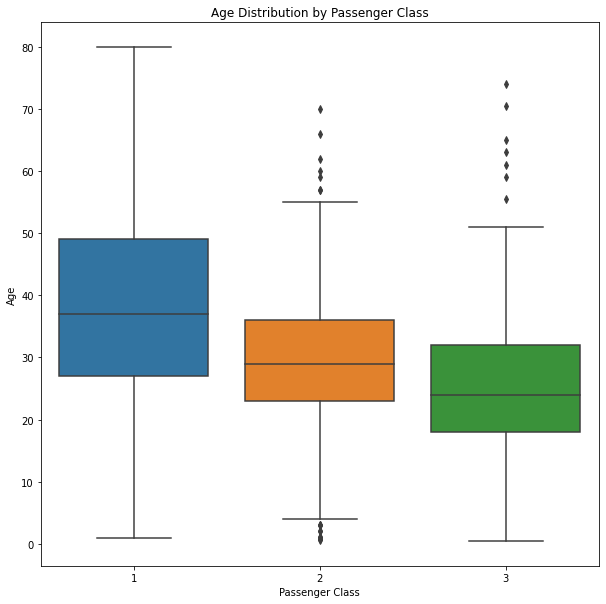

In [28]:
# distribution of age by passenger class

plt.figure(figsize=(10, 10))
sns.boxplot(x='pclass', y='age', data=df_final)
plt.title('Age Distribution by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.show()

In [29]:
null_current = df_final.isnull().sum()
print(null_current)

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
who              0
embark_town      2
alone            0
dtype: int64


In [31]:
impute_age = lambda row: median_class[row['pclass']] if pd.isnull(row['age']) else row['age']

df_final['age'] = df_final.apply(impute_age, axis=1)
print(df_final['age'].isnull().sum())

0


In [32]:
df_final = df_final.dropna()
print(df_final.isnull().sum())

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
who            0
embark_town    0
alone          0
dtype: int64


In [37]:
df_final.shape[0]

889

In [38]:
print(df_final.dtypes)

survived         int64
pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
who             object
embark_town     object
alone             bool
dtype: object


Currently sex, who, embark_town & alone are categorical

survived, pclass, sibsp & parch could also be categorical

In [39]:
# convert categorical features to numeric dummies

df_final = pd.get_dummies(df_final, drop_first=True)
df_final.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton
0,0,3,22.0,1,0,7.2500,False,1,1,0,0,1
1,1,1,38.0,1,0,71.2833,False,0,0,1,0,0
2,1,3,26.0,0,0,7.9250,True,0,0,1,0,1
3,1,1,35.0,1,0,53.1000,False,0,0,1,0,1
4,0,3,35.0,0,0,8.0500,True,1,1,0,0,1


In [40]:
# test train split

x = df_final.drop(columns=['survived'])
y = df_final['survived']  # target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y, random_state=42)

In [41]:
# percentage of surviviors maintained 

total_survival_rate = y.mean() * 100
train_survival_rate = y_train.mean() * 100
test_survival_rate = y_test.mean() * 100

print(total_survival_rate)
print(train_survival_rate)
print(test_survival_rate)

38.24521934758155
38.25597749648382
38.20224719101123


# Part 2: Initial Model Training

In [48]:
# instantiate models

logistic_model = LogisticRegression(random_state=42)
svc_model = SVC(probability=True, random_state=42) 
decision_tree_model = DecisionTreeClassifier(random_state=42)

In [51]:
# probability predictions 

logistic_prob = cross_val_predict(logistic_model, x_train, y_train, cv=5, method='predict_proba')[:, 1]  
svc_prob = cross_val_predict(svc_model, x_train, y_train, cv=5, method='predict_proba')[:, 1]  
decision_tree_prob = cross_val_predict(decision_tree_model, x_train, y_train, cv=5, method='predict_proba')[:, 1]  

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [57]:
def evaluate_classifier(classifier_name, y_true, y_probs):
    
    y_pred = np.where(y_probs >= 0.5, 1, 0)
    
    # classification report
    report = classification_report(y_true, y_pred)
    print(f"Classification Report for {classifier_name}:\n{report}")

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix for {classifier_name}:\n{cm}\n")
    
    # ROC-AUC score
    roc_auc = roc_auc_score(y_true, y_probs)
    print(f"ROC-AUC Score for {classifier_name}: {roc_auc:.4f}\n")

evaluate_classifier("Logistic Regression", y_train, logistic_prob)
evaluate_classifier("Support Vector Classifier", y_train, svc_prob)
evaluate_classifier("Decision Tree Classifier", y_train, decision_tree_prob)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       439
           1       0.78      0.74      0.76       272

    accuracy                           0.82       711
   macro avg       0.81      0.81      0.81       711
weighted avg       0.82      0.82      0.82       711

Confusion Matrix for Logistic Regression:
[[383  56]
 [ 71 201]]

ROC-AUC Score for Logistic Regression: 0.8568

Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.68      0.90      0.78       439
           1       0.68      0.33      0.44       272

    accuracy                           0.68       711
   macro avg       0.68      0.62      0.61       711
weighted avg       0.68      0.68      0.65       711

Confusion Matrix for Support Vector Classifier:
[[397  42]
 [183  89]]

ROC-AUC Score for Support Vector Classifier: 0.7481

Classifi

# Part 3: Model Tuning

In [59]:
scaler = StandardScaler()

x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.transform(x_test)

In [61]:
svc = SVC(probability=True, random_state=42)

svc_prob = cross_val_predict(svc, x_train_scale, y_train, cv=5, method='predict_proba')[:, 1]

evaluate_classifier("Support Vector Classifier", y_train, svc_prob)

Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       439
           1       0.82      0.69      0.75       272

    accuracy                           0.82       711
   macro avg       0.82      0.80      0.80       711
weighted avg       0.82      0.82      0.82       711

Confusion Matrix for Support Vector Classifier:
[[397  42]
 [ 85 187]]

ROC-AUC Score for Support Vector Classifier: 0.8417



Evaluation metrics improved after scaling the training data:
    - precision: 0.68 unscaled, 0.82 scaled
    - recall: 0.33 unscaled, 0.69 scaled
    - f1 score: 0.44 unscaled, 0.75 scaled
    - accuracy: 0.68 unscaled, 0.82 scaled
    - roc-auc: 0.75 unscaled, 0.84 scaled

In [64]:
param_grid = {
    'kernel': ['rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'C': [1, 10, 50, 100, 200, 300]
}

svc = SVC(probability=True)

grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=5,
                           n_jobs=-1)

grid_search.fit(x_train_scale, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

Best Parameters: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best ROC-AUC Score: 0.84984951394826


In [65]:
best_svc = grid_search.best_estimator_

y_pred = best_svc.predict(x_test_scale)
y_pred_proba = best_svc.predict_proba(x_test_scale)[:, 1]

# classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       110
           1       0.00      0.00      0.00        68

    accuracy                           0.62       178
   macro avg       0.31      0.50      0.38       178
weighted avg       0.38      0.62      0.47       178

Confusion Matrix:
[[110   0]
 [ 68   0]]
ROC-AUC Score: 0.8405080213903743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
